# RStan Demo: Two-Patient Stand ODE Model

This notebook expands the PKPD Meta 105 workflow to two synthetic BCVA records and runs the existing `stand_ode.stan` program with RStan. The goal is to show the single-patient model operating on per-patient slices while sketching the transition toward a population workflow.


The steps mirror the CmdStanPy notebook but with R tooling:

- confirm RStan and helpers are available
- build two longitudinal patient schedules to mimic trial data
- compile `stand_ode.stan` once and reuse it
- sample each patient independently, summarising parameters and posterior predictive checks


In [1]:
required_pkgs <- c("rstan")
missing_pkgs <- required_pkgs[!vapply(required_pkgs, requireNamespace, logical(1), quietly = TRUE)]
if (length(missing_pkgs) > 0) {
  install.packages(missing_pkgs, repos = "https://cloud.r-project.org")
}
library(rstan)
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())


Loading required package: StanHeaders


rstan version 2.32.7 (Stan version 2.32.2)


For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)




In [2]:
stan_file <- if (file.exists("stand_ode.stan")) {
  "stand_ode.stan"
} else if (file.exists("content/ipynb/stand_ode.stan")) {
  "content/ipynb/stand_ode.stan"
} else {
  stop("Stan file not found next to this notebook.")
}
stand_ode_model <- rstan::stan_model(file = stan_file)
stand_ode_model


S4 class stanmodel 'anon_model' coded as follows:
functions {
  vector drug_disease_stim_kinL_Et_ode(real t,
                                       vector y,
                                       array[] real theta,
                                       array[] real x_r,
                                       array[] int x_i) {
    vector[1] dydt;
    real emax_0 = theta[1];
    real lec_50 = theta[2];
    real r180 = theta[3];
    real beta = theta[4];
    real k_in = theta[5];
    real k_out = theta[6];
    real start_t = x_r[1];
    real lconc_0 = x_r[2];
    real K = x_r[3];
    real hill = x_r[4];
    real lconcentration = lconc_0 - K * (t - start_t);
    real emax = emax_0 * (r180 + (1 - r180) * exp(-beta * t / 30.0));
    real stim = emax * inv_logit(hill * (lconcentration - lec_50));
    dydt[1] = k_in - k_out * (y[1] - stim);
    return dydt;
  }
}
data {
  int<lower=1> N;
  vector[N] time;
  vector[N] bcva_obs;
  real start_t;
  real lconc0;
  real<lower=0> K;
  real hill;


In [3]:
visit_schedule <- c(0.0, 7.0, 14.0, 28.0, 56.0, 84.0)
patient_data <- data.frame(
  patient_id = rep(c("patient_01", "patient_02"), each = length(visit_schedule)),
  time = rep(visit_schedule, times = 2),
  bcva = c(45.0, 47.5, 50.0, 54.0, 57.0, 58.5,
           52.0, 54.0, 56.5, 60.0, 63.0, 64.0)
)
patient_data


patient_id,time,bcva
<chr>,<dbl>,<dbl>
patient_01,0,45.0
patient_01,7,47.5
patient_01,14,50.0
patient_01,28,54.0
patient_01,56,57.0
patient_01,84,58.5
patient_02,0,52.0
patient_02,7,54.0
patient_02,14,56.5


In [4]:
hyperparameters <- list(
  lconc0 = 1.6,
  K = 0.0045,
  hill = 4.0,
  r180 = 0.65,
  beta = 0.35,
  sigma_prior_scale = 5.0
)
make_stan_data <- function(df, hyper) {
  list(
    N = nrow(df),
    time = df$time,
    bcva_obs = df$bcva,
    start_t = df$time[1],
    lconc0 = hyper$lconc0,
    K = hyper$K,
    hill = hyper$hill,
    r180 = hyper$r180,
    beta = hyper$beta,
    sigma_prior_scale = hyper$sigma_prior_scale
  )
}
patient_slices <- split(patient_data, patient_data$patient_id)
stan_inputs <- lapply(patient_slices, make_stan_data, hyper = hyperparameters)
str(stan_inputs, max.level = 1)


List of 2
 $ patient_01:List of 10
 $ patient_02:List of 10


In [5]:
fit_list <- lapply(stan_inputs, function(data_list) {
  rstan::sampling(
    object = stand_ode_model,
    data = data_list,
    seed = 24531,
    chains = 4,
    iter = 1000,
    warmup = 500,
    refresh = 100,
    control = list(adapt_delta = 0.9)
  )
})
names(fit_list) <- names(stan_inputs)
fit_list


Warning message:
“There were 7 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#tail-ess”


 3.387 seconds (Total)
Chain 4: 
Chain 1: Iteration: 1000 / 1000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 1.739 seconds (Warm-up)
Chain 1:                1.731 seconds (Sampling)
Chain 1:                3.47 seconds (Total)
Chain 1: 


Warning message:
“There were 15 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#tail-ess”


$patient_01
Inference for Stan model: anon_model.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

              mean se_mean   sd   2.5%    25%    50%   75% 97.5% n_eff Rhat
k_in          0.01    0.00 0.00   0.01   0.01   0.01  0.01  0.02   350 1.02
k_out         0.03    0.00 0.01   0.02   0.03   0.03  0.04  0.05   475 1.01
emax0         0.72    0.01 0.31   0.13   0.50   0.72  0.92  1.33   520 1.01
lec50         2.21    0.03 0.41   1.33   1.97   2.22  2.46  3.02   254 1.03
sigma         0.66    0.03 0.51   0.21   0.34   0.50  0.78  2.01   303 1.00
R0           -0.22    0.00 0.03  -0.28  -0.23  -0.21 -0.20 -0.17   662 1.00
mu_bcva[1]   44.61    0.03 0.67  43.03  44.36  44.67 44.93 45.79   664 1.00
mu_bcva[2]   47.83    0.02 0.46  47.00  47.63  47.80 47.99 48.89   889 1.00
mu_bcva[3]   50.35    0.02 0.48  49.65  50.11  50.27 50.50 51.51   865 1.00
mu_bcva[4]   53.84    0.02 0.51  53.08  53.55  53.76 54.02 55.12   876 1.0

In [6]:
target_params <- c("k_in", "k_out", "emax0", "lec50", "sigma", "R0")
extract_param_summary <- function(fit, id) {
  sm <- summary(fit, pars = target_params)$summary
  data.frame(
    patient_id = id,
    parameter = rownames(sm),
    mean = sm[, "mean"],
    sd = sm[, "sd"],
    n_eff = sm[, "n_eff"],
    rhat = sm[, "Rhat"],
    row.names = NULL
  )
}
parameter_summaries <- do.call(rbind, Map(extract_param_summary, fit_list, names(fit_list)))
parameter_summaries


,patient_id,parameter,mean,sd,n_eff,rhat
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
patient_01.1,patient_01,k_in,0.01120366,0.002345378,349.98707,1.022451
patient_01.2,patient_01,k_out,0.03283366,0.006236220,474.65311,1.010317
patient_01.3,patient_01,emax0,0.71771459,0.305488771,520.33696,1.011738
patient_01.4,patient_01,lec50,2.21234787,0.410759088,253.67998,1.026483
patient_01.5,patient_01,sigma,0.65788220,0.510737748,302.72243,1.003369
patient_01.6,patient_01,R0,-0.21667052,0.027286589,662.33304,1.000091
patient_02.1,patient_02,k_in,0.01853699,0.004605524,80.47795,1.051272
patient_02.2,patient_02,k_out,0.03307144,0.006931699,374.28791,1.010762
patient_02.3,patient_02,emax0,0.71162910,0.292067376,613.92086,1.005215


In [7]:
posterior_curves <- do.call(
  rbind,
  Map(function(fit, id) {
    draws <- rstan::extract(fit, pars = "bcva_rep")$bcva_rep
    mean_bcva <- apply(draws, 2, mean)
    lower <- apply(draws, 2, quantile, probs = 0.05)
    upper <- apply(draws, 2, quantile, probs = 0.95)
    df <- patient_slices[[id]]
    data.frame(
      patient_id = id,
      time = df$time,
      observed = df$bcva,
      posterior_mean = mean_bcva,
      lower = lower,
      upper = upper
    )
  }, fit_list, names(fit_list))
)
posterior_curves


,patient_id,time,observed,posterior_mean,lower,upper
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
patient_01.1,patient_01,0,45.0,44.63516,43.03094,46.02366
patient_01.2,patient_01,7,47.5,47.82622,46.58623,49.30274
patient_01.3,patient_01,14,50.0,50.33519,49.16143,51.82781
patient_01.4,patient_01,28,54.0,53.84029,52.61204,55.49627
patient_01.5,patient_01,56,57.0,57.16383,55.86678,58.56201
patient_01.6,patient_01,84,58.5,58.31521,56.69245,59.84039
patient_02.1,patient_02,0,52.0,51.41049,49.55521,52.92820
patient_02.2,patient_02,7,54.0,54.45436,53.09144,55.89043
patient_02.3,patient_02,14,56.5,56.82512,55.57153,58.34546


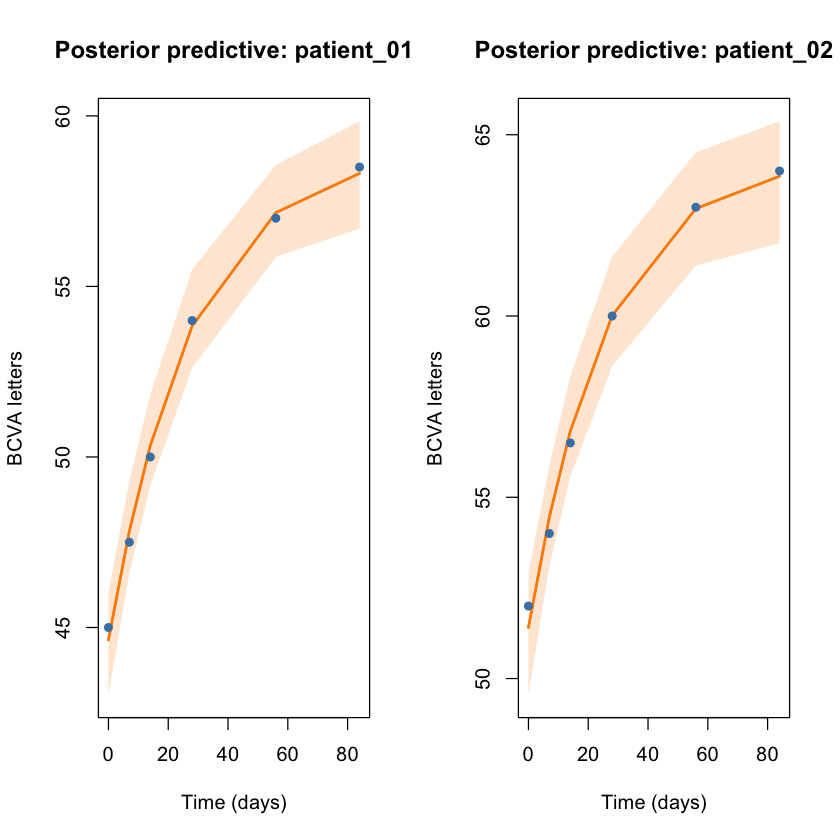

In [8]:
op <- par(mfrow = c(1, length(patient_slices)))
for (id in names(patient_slices)) {
  curve_df <- subset(posterior_curves, patient_id == id)
  ylim_range <- range(c(curve_df$lower, curve_df$upper, curve_df$observed))
  plot(curve_df$time, curve_df$posterior_mean,
       type = "l", lwd = 2, col = "darkorange",
       ylim = ylim_range,
       xlab = "Time (days)", ylab = "BCVA letters",
       main = paste("Posterior predictive:", id))
  polygon(
    x = c(curve_df$time, rev(curve_df$time)),
    y = c(curve_df$lower, rev(curve_df$upper)),
    col = grDevices::adjustcolor("darkorange", alpha.f = 0.2),
    border = NA
  )
  lines(curve_df$time, curve_df$posterior_mean, col = "darkorange", lwd = 2)
  points(curve_df$time, curve_df$observed, pch = 16, col = "steelblue")
}
par(op)


Running the model on patient-specific slices keeps the ODE and priors identical to the single-subject workflow while revealing cross-patient differences in the posterior summaries. These fits set up the next step toward a population model—pooling or hierarchically linking the shared parameters once individual behaviour is validated.
